In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.datasets.fersynthetic  import SyntheticFaceDataset
from pytvision.datasets.factory  import FactoryDataset
from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
# from torchlib.datasets.fersynthetic  import SyntheticFaceDataset
# from torchlib.datasets.factory  import FactoryDataset

In [2]:
pathnamedata  = '~/.datasets'
pathnameback  = '~/.datasets/coco'
imsize        = 128
idenselect    = [0,1,2,3,4,5,6,7,8,9]

In [4]:
data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.affectdark, 
    subset=FactoryDataset.validation, 
#     idenselect=idenselect,
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.2, warp=0.1, factor=0.2,
)

print( len(dataset) )

4000


In [6]:
def lincomb(im1,im2,mask,alpha=0.5):
    im = im1.copy()     
    row, col = np.where(mask != 0)
    for i in range( len(row) ):
        r,c = row[i],col[i]
        im[r,c,0] = im1[r,c,0]*(1-alpha) + im2[r,c,0]*(alpha)
        im[r,c,1] = im1[r,c,1]*(1-alpha) + im2[r,c,1]*(alpha)
        im[r,c,2] = im1[r,c,2]*(1-alpha) + im2[r,c,2]*(alpha)
    return im

def setcolor(im, mask, color):    
    tmp=im.copy()
    tmp=np.reshape( tmp, (-1, im.shape[2])  )   
    mask = np.reshape( mask, (-1,1))      
    tmp[ np.where(mask>0)[0] ,:] = color
    im=np.reshape( tmp, (im.shape)  )
    return im

def makecolormask( mask, color=[1,0,0] ):
    colormask = np.zeros( (mask.shape[0], mask.shape[1], 3) )    
    colormask = setcolor(colormask, mask, color )        
    return colormask

(276, 276, 3) 0 255
(276, 276, 2) 0.0 1.0


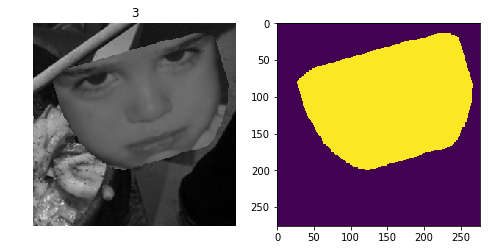

In [16]:

sample = dataset[ np.random.randint( len(dataset) )  ]   
image, mask, meta = sample['image'], sample['label'], sample['metadata']
label = meta[0]

print(image.shape, image.min(), image.max())
print(mask.shape, mask.min(), mask.max() )

mask = mask[:,:,1]
colormask = makecolormask( mask, color=[1,0,0] )

plt.figure( figsize=(8,8) )
plt.subplot(121)
#plt.imshow( lincomb( image/255, colormask, mask, alpha=0.3 ) )
#plt.imshow(mask)
plt.imshow(image)
#plt.imshow(mask, cmap='seismic', alpha=0.2)
plt.title( label )
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)

plt.show()



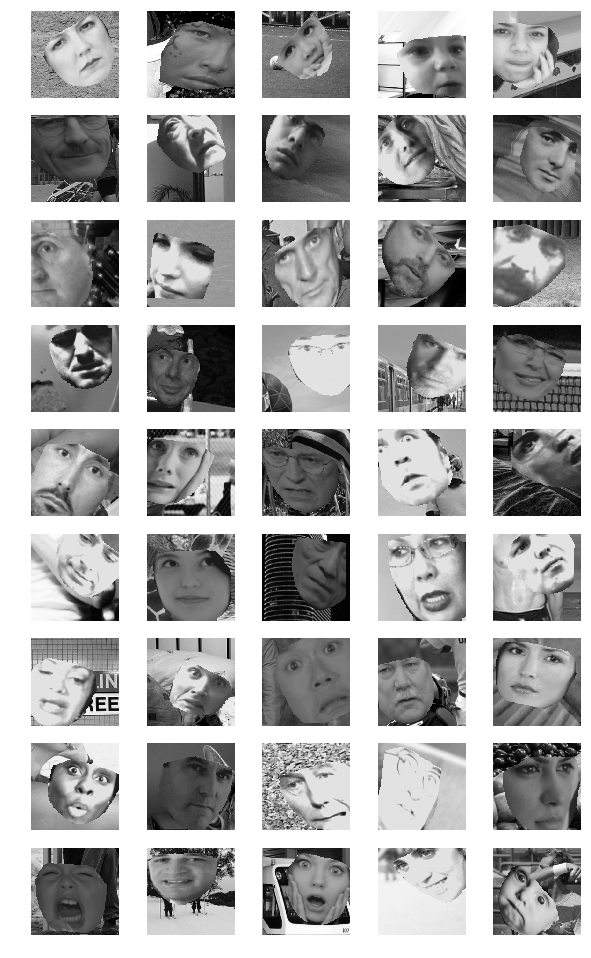

In [17]:
import matplotlib
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (10,17)

numRows = 9; numCols = 5

plt.figure()
for k in range(numRows*numCols):
    sample = dataset[ np.random.randint( len(dataset) )  ]  
    image, mask, meta = sample['image'], sample['label'], sample['metadata']
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow( image )
    #plt.imshow( mask[:,:,1], cmap='seismic', alpha=0.2)
    #plt.title( label )
    plt.axis('off')
    

In [18]:
def visualizatedataset( data, num=25, imsize=(64,64,3), padding=1 ):        
    databatch = torch.zeros( [num, imsize[2], imsize[0], imsize[1]], dtype=torch.float32 )
    for i in range(num): 
        idx = i # np.random.randint( len(data) )
        databatch[i,...] = data[idx]['image']
    grid = utils.make_grid( databatch , nrow= int(np.sqrt(num)), normalize=True, padding=padding )       
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


In [23]:

size_input=64

data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.affectdark, 
    subset=FactoryDataset.validation, 
#     idenselect=idenselect,
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=30, translation=0.2, warp=0.1, factor=0.2, 
    transform=transforms.Compose([            
        #------------------------------------------------------------------
        #Geometric 
        #mtrans.RandomScale(factor=0.2, padding_mode=cv2.BORDER_REPLICATE ), 
        #mtrans.ToRandomTransform( mtrans.RandomGeometricalTransform( angle=30, translation=0.2, warp=0.02, padding_mode=cv2.BORDER_REPLICATE ), prob=0.5 ),
        #mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),
        #mtrans.ToRandomTransform( mtrans.HFlip(), prob=0.5 ),
        #------------------------------------------------------------------
        #Colors 
        #mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.25 ), prob=0.50 ),
        #mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.25 ), prob=0.50 ),
        #mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.25 ), prob=0.50 ),
        #mtrans.ToRandomTransform( mtrans.RandomRGBPermutation(), prob=0.50 ),
        #mtrans.ToRandomTransform( mtrans.CLAHE(), prob=0.25 ),
        mtrans.ToRandomTransform( mtrans.ToGaussianBlur( sigma=0.05 ), prob=0.25 ),
        #------------------------------------------------------------------
        #Resize
        mtrans.ToResize( (size_input+5, size_input+5), resize_mode='square' ),
        mtrans.RandomCrop( (size_input, size_input), limit=2, padding_mode=cv2.BORDER_REPLICATE  ), 
        #------------------------------------------------------------------
        mtrans.ToTensor(),
        #mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], )
        mtrans.ToNormalization(),
        ])
)



dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0 )
print( len(dataset) )


4000


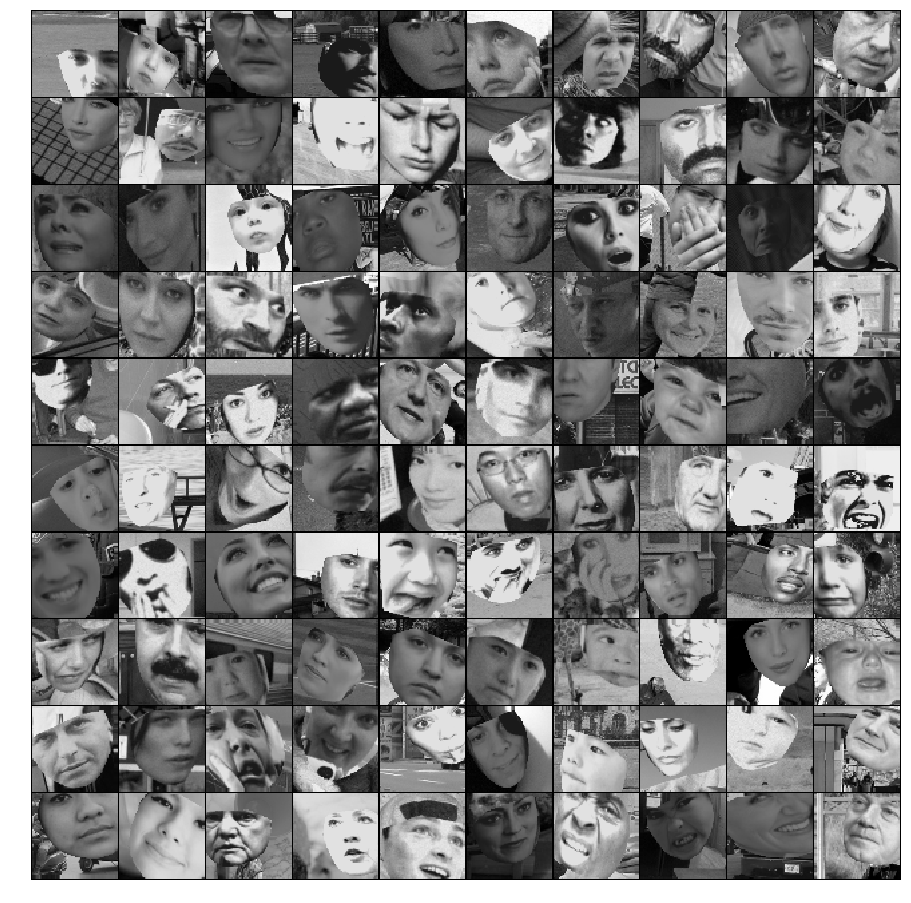

In [24]:
plt.figure( figsize=(16,16))
visualizatedataset(dataset, num=100, imsize=(size_input,size_input,3), padding=1 )
plt.axis('off')
plt.ioff()
plt.show() 

torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 64, 64]) torch.Size([4, 1])


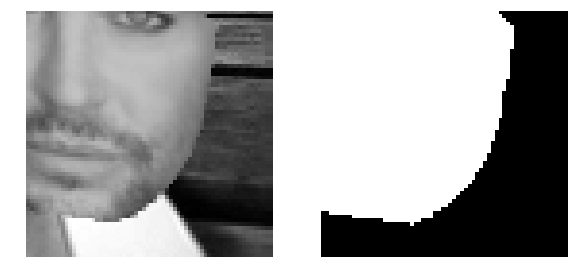

torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 64, 64]) torch.Size([4, 1])


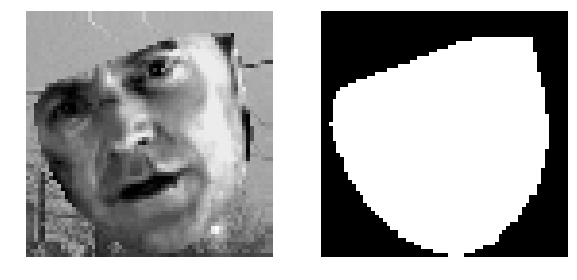

torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 64, 64]) torch.Size([4, 1])


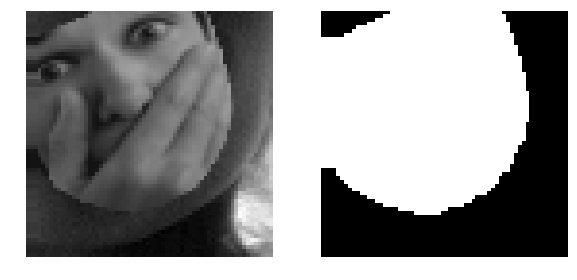

torch.Size([4, 3, 64, 64]) torch.Size([4, 2, 64, 64]) torch.Size([4, 1])


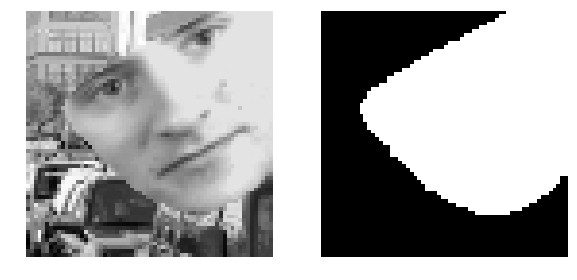

In [25]:
label_batched = []
for i_batch, sample in enumerate(dataloader):
    x_img, y_mask, y_lab = sample['image'], sample['label'], sample['metadata']
    print(x_img.shape, y_mask.shape, y_lab.shape)
    
    image = x_img[0,0,...]
    mask  = y_mask[0,1,...]
    
    # observe 4th batch and stop.        
    plt.figure( figsize=(15,15) )
    plt.subplot(131)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.ioff()

    plt.subplot(132)
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.ioff()        
    plt.show()   
        
    if i_batch == 3:
        break